# 4DSTEM scan builder

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time

In [2]:
def extract_electron_pattern(df, evt, center_row=50, center_col=50, window_size=101):
    half_window = window_size // 2
    pattern_df = df[df.event == evt]
    pattern_df = pattern_df[(pattern_df['row'].between(center_row - half_window, center_row + half_window)) &
                    (pattern_df['col'].between(center_col - half_window, center_col + half_window))]
    
    electron_pattern = np.zeros((window_size, window_size), dtype=int)
    for _, hit in pattern_df.iterrows():
        electron_pattern[hit['row'] - (center_row - half_window),
                         hit['col'] - (center_col - half_window)] += hit['counts']
    return electron_pattern

def create_frame(n, hit_positions, df):
    frame = np.zeros((n, n), dtype=int)
    
    # Obtain unique events to choose from
    unique_events = df['event'].unique()
    
    # Position each electron hit in the frame
    for x, y in hit_positions:
        evt = random.choice(unique_events)  # Randomly select an event
        electron_pattern = extract_electron_pattern(df, evt)
        
        # Get the electron pattern size
        whole_window = len(electron_pattern)

        # Determine the position of the top-left corner where the electron pattern will be positioned (assuming it fits).
        half_window = whole_window // 2
        top_left_x = x - half_window
        top_left_y = y - half_window

        # Calculate the bounds of the pattern slice within the frame
        start_i = max(0, -top_left_x)
        start_j = max(0, -top_left_y)
        end_i = min(n - top_left_x, whole_window)
        end_j = min(n - top_left_y, whole_window)

        # Calculate the frame slice where the pattern will be added
        frame_slice_x_start = max(0, top_left_x)
        frame_slice_y_start = max(0, top_left_y)
        frame_slice_x_end = frame_slice_x_start + (end_i - start_i)
        frame_slice_y_end = frame_slice_y_start + (end_j - start_j)

        # Add the electron pattern slice to the frame slice
        frame[frame_slice_x_start:frame_slice_x_end, frame_slice_y_start:frame_slice_y_end] += \
            electron_pattern[start_i:end_i, start_j:end_j]
    
    return frame

In [3]:
# Load DataFrame
df_fname = "../dataframes/EM_5um_front_3M_100keV.pkl"
df = pd.read_pickle(df_fname)

# Example usage
N = 101  # Size of the frame
hit_positions = [(50, 50)]*100
hit_positions_2 = [(60, 40)]*100
hit_positions = hit_positions + hit_positions_2

frame = create_frame(N, hit_positions, df)

/var/folders/05/5x88pkbj3yb7x2vwsxtwvmdm0000gn/T/ipykernel_7397/243576165.py:5: RuntimeWarning: divide by zero encountered in log10
  logframe = np.log10(frame)


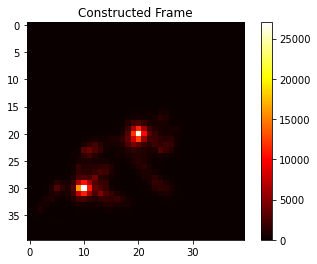

In [8]:
# Visualize the frame
rng_low = 30 
rng_high = 70

logframe = np.log10(frame)

plt.imshow(frame[rng_low:rng_high,rng_low:rng_high], cmap='hot', interpolation='nearest')
#plt.imshow(logframe[rng_low:rng_high,rng_low:rng_high], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Constructed Frame')
plt.show()

### Look at a single electron event from the dataframe

In [ ]:
win = 10
evt = 5
df_evt = df[df.event == evt]
evt_arr = np.zeros([101,101])
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
evt_arr = evt_arr[50-win:50+win,50-win:50+win]